## Разбиение на train и test

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import sqlite3
from sklearn.model_selection import train_test_split
from scipy.sparse import lil_matrix, save_npz, load_npz

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('user_song_df.csv')

In [3]:
data.drop(['Unnamed: 0', 'track_id'], axis=1, inplace=True)

In [4]:
data.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston
1,fd13b9d49c54e00ff413fe3c095ba581c7fc611e,SOAPDEY12A81C210A9,8,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston
2,35752a9e4d917c8fc5da88e90c25adc6b52220b6,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston
3,bfe8d6d1e32d9de12c632d68712e7e4a23416e93,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston
4,46d3ef1b4f317aba8f0226e937c67ecef9fa2e42,SOAPDEY12A81C210A9,4,Nothing from Nothing,To Die For,Billy Preston,1974,r&b,United States,Houston


In [5]:
data.shape

(45795099, 10)

In [6]:
train, test = train_test_split(data, 
                               stratify=data['user_id'], 
                               test_size=0.20, 
                               random_state=17)

print(f'Размер train: {len(train)}')
print(f'Размер test: {len(test)}')

Размер train: 36636079
Размер test: 9159020


Посмотрим, сколько всего есть уникальных пользователей и песен в train и test

In [7]:
print(f'Пользователей в train: {train.user_id.nunique()}')
print(f'Песен в train: {train.song_id.nunique()}', end='\n\n')\

print(f'Пользователей в test: {test.user_id.nunique()}')
print(f'Песен в test: {test.song_id.nunique()}', end='\n\n')

Пользователей в train: 1019318
Песен в train: 370860

Пользователей в test: 1019318
Песен в test: 299115



Посмотрим на распределение числа прослушиваний песен для train и test

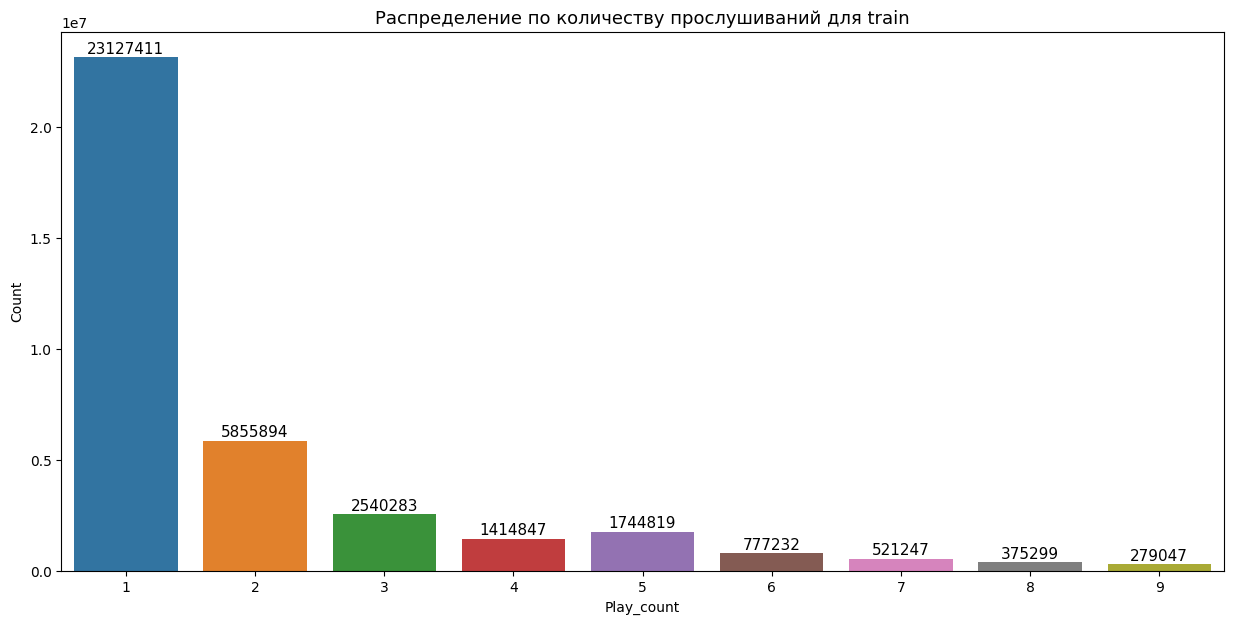

In [8]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=train);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 200000, 
            int(rect.get_height()), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний для train', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

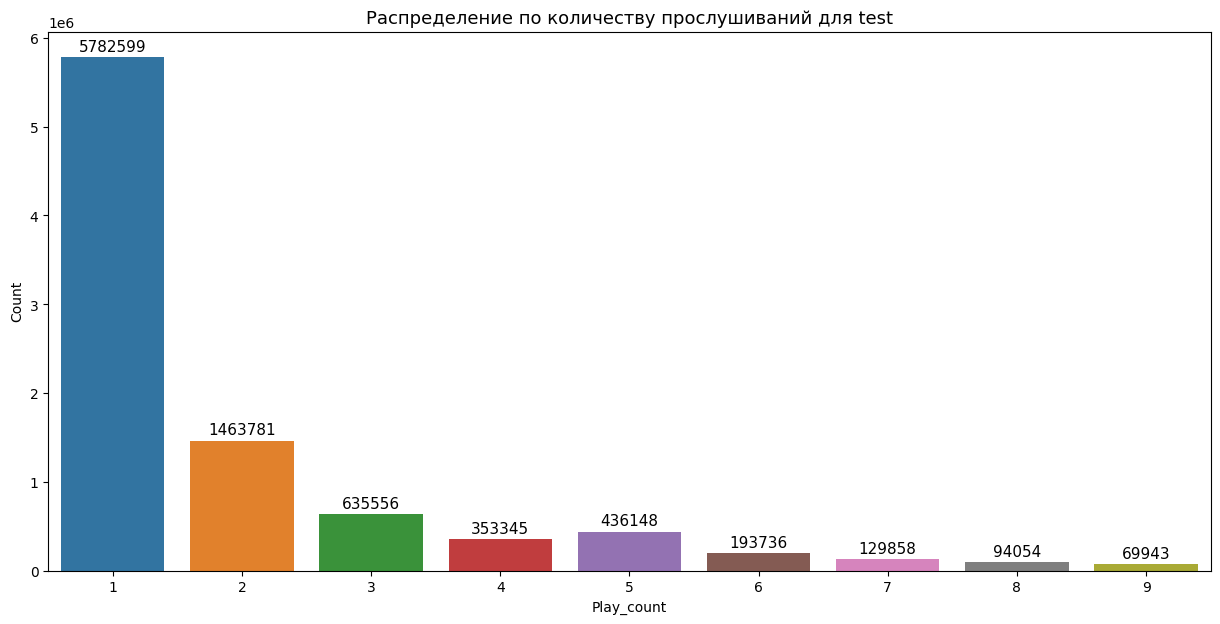

In [9]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=test);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 70000, 
            int(rect.get_height()), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний для test', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

Распределение после разбиения осталось неизменным

In [10]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

## SQL

Так как таблицы получились достаточно большими, будем хранить их, используя базу данных SQLite.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,90304980e055c1d0e11d84b2478fc61ac0869e2f,SOBBKFZ12A5891FDF6,4,Red Alibi,The Wiretap Scars,Sparta,2002,rock,No country,No city
1,c3d52f37f1538fabaa8aa417faee81317103c42c,SOGDNJX12A6D4F85BC,1,Love Will Turn You Around (2006 Digital Remaster),Number Ones,Kenny Rogers,0,country,United States,Houston
2,c329c8bad310cdc6b5fb8ef2ad349062921482d3,SODEYXA12A3F1EBF5F,1,I've Got A New Heartache,Country Gentleman: The Best Of Ricky Skaggs,Ricky Skaggs,1998,country,United States,Cordell
3,ce1b7bc9c1893e2a3b1674e6431a075ce03b7f46,SOFFAVD12A67020C61,1,No Matter What,...By Request,Boyzone,1998,pop,Ireland,Dublin
4,67960fb8a659577fb643a1a08923f818e3489c78,SOISUWI12A6D4F5708,6,Starlight,Starlight,Muse,0,rock,United Kingdom,Teignmouth


In [3]:
conn = sqlite3.connect('music_rates.db')

In [4]:
cursor = conn.cursor()

In [6]:
train.to_sql(name='train', con=conn)

36636079

In [7]:
test.to_sql(name='test', con=conn)

9159020

In [8]:
del train, test

In [10]:
def make_sparse_matrix(table_name: str):
    
    users_sql = f"""
        SELECT DISTINCT user_id
        FROM {table_name}
    """
    cursor.execute(users_sql)

    user_to_row = {}
    for row_id, (user_id,) in enumerate(cursor):
        user_to_row[user_id] = row_id
    
    song_sql = f"""
        SELECT DISTINCT song_id
        FROM {table_name}
    """
    cursor.execute(song_sql)

    song_to_col = {}
    for col_id, (song_id,) in enumerate(cursor):
        song_to_col[song_id] = col_id
        
    print(f"Количество пользователей в {table_name}:", len(user_to_row))
    print(f"Количество песен в {table_name}:", len(song_to_col))
    
    query = f"""
        SELECT user_id, song_id, play_count
        FROM {table_name}
    """
    cursor.execute(query)
    
    matrix = lil_matrix((len(user_to_row), len(song_to_col)))
    
    # заполняем матрицу
    for user_id, song_id, play_count in cursor:
        row_id = user_to_row.get(user_id)
        col_id = song_to_col.get(song_id)
        matrix[row_id, col_id] = play_count
        
    return matrix

In [11]:
train_sparse_matrix = make_sparse_matrix('train')
test_sparse_matrix = make_sparse_matrix('test')

Количество пользователей в train: 1019318
Количество песен в train: 370860
Количество пользователей в test: 1019318
Количество песен в test: 299115


In [12]:
train_sparse_matrix

<1019318x370860 sparse matrix of type '<class 'numpy.float64'>'
	with 36636079 stored elements in List of Lists format>

In [13]:
test_sparse_matrix

<1019318x299115 sparse matrix of type '<class 'numpy.float64'>'
	with 9159020 stored elements in List of Lists format>

### Сохраним полученные матрицы

In [16]:
save_npz('train_sparse_matrix.npz', train_sparse_matrix.tocoo())
save_npz('test_sparse_matrix.npz', test_sparse_matrix.tocoo())

In [21]:
# train_sparse = load_npz('train_sparse_matrix.npz')
# train_sparse